## Reviews_Declined
This is the reference implementation for [Reviews Declined](https://github.com/chaoss/wg-evolution/blob/master/metrics/Reviews_Declined.md),
a metric specified by the
[Evolution Working Group](https://github.com/chaoss/wg-evolution) of the
[CHAOSS project](https://chaoss.community).
This implementation is specific to Git repositories.

Have a look at [README.md](../README.md) to find out how to run this notebook (and others in this directory) as well as to get a better understanding of the purpose of the implementations.

The implementation is described in two parts (see below):

* Class for computing Reviews Declined
* An explanatory analysis of the class' functionality

Some more auxiliary information in this notebook:

* Examples of the use of the implementation

As discussed in the [README](../README.md) file, the scripts required to analyze the data fetched by Perceval are located in the `code_df` package. Due to python's import system, to import modules from a package which is not in the current directory, we have to either add the package to `PYTHONPATH` or simply append a `..` to `sys.path`, so that `code_df` can be successfully imported. 

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from code_df import utils
from code_df import conditions
from code_df.pullrequest_github import PullRequestGitHub
%matplotlib inline

In [2]:
class ReviewsDeclinedGitHub(PullRequestGitHub):
    """
    Class for Reviews Declined
    """

    def compute(self):
        """
        Compute the total number of reviews which were declined, from the
        Perceval data. Declined reviews are in the "closed" state but
        are not merged.

        :returns count: The total number of reviews declined
        """

        count = len(self.df['hash'][~self.df['merged']
                    & (self.df['current_status'] == 'closed')].unique())
        return count

    def _agg(self, df, period):
        """
        Perform an aggregation operation on a DataFrame to find
        the total number of reviews declined in every
        interval of the period specified in the time_series method,
        like 'M', 'W',etc.

        It computes the count of the "category" column of the
        DataFrame for those rows with the 'merge' column having False.

        :param df: a pandas DataFrame on which the aggregation will be
            applied.

        :param period: A string which can be any one of the pandas time
            series rules:
            'W': week
            'M': month
            'D': day

        :returns df: The aggregated dataframe, where aggregations have
            been performed on the "category" column
        """

        df = df[~df['merged']
                & (df['current_status'] == 'closed')]
        df = df.resample(period)['category'].agg(['count'])

        return df

## Performing the Analysis
Lets perform two kinds of analysis here:
- computing the number of reviews declined in a given period
- finding the trends in the number of reviews declined over time

### Counting the total number of reviews declined
We first read the JSON file containing Perceval data using the `read_json_file` utility function. 

In [3]:
items = utils.read_json_file('../pull_requests.json')

Let's use the `compute` method to count the total number of declined reviews. First, we will do it without passing any since and until dates. 
Next, we can pass in the start and end dates as a tuple. The format would be `%Y-%m-%d`.
Let's also find the number of declined reviews created after a certain date. Here, we would pass a valid `datetime` object for the `since` part of `date_range`, leaving the `until` part as `None`.

In [4]:
reviews_declined = ReviewsDeclinedGitHub(items)
print("The total number of reviews declined "
      "in the data is {}.".format(reviews_declined.compute()))

date_since = datetime.strptime("2018-01-01", "%Y-%m-%d")
date_until = datetime.strptime("2018-07-01", "%Y-%m-%d")    

reviews_declined_dated = ReviewsDeclinedGitHub(items,
                        date_range=(date_since, date_until))
                        
print("The total number of reviews created between "
      "2018-01-01 and 2018-07-01 that were declined is {}.".format(reviews_declined_dated.compute()))

reviews_declined_since = ReviewsDeclinedGitHub(items,
                        date_range=(date_since, None))
                        
print("The total number of reviews created after "
      "2018-01-01  that were declined is {}.".format(reviews_declined_since.compute()))

The total number of reviews declined in the data is 18.
The total number of reviews created between 2018-01-01 and 2018-07-01 that were declined is 5.
The total number of reviews created after 2018-01-01  that were declined is 12.


## Computing the number of accepted reviews over regular time intervals
Using the `time_series` method, it is possible to compute the number of reviews declined every month, every week or any valid pandas timeseries period. This kind of analysis is useful in finding trends over time, as we will see in the cell below.

Let's perform a basic analysis: lets see the change in the number of reviews declined, between the same dates we used above on a weekly basis: 2018-01-01 and 2018-07-01. 
The `ReviesDeclinedZGitHub` object, `reviews_declined_dated`, will be used again.

In [5]:
weekly_df = reviews_declined_dated.time_series(period='W')

Lets see what the dataframe returned by `time_series` looks like. As you will notice, the dataframe has rows corresponding to each and every week between the start and end dates. To do this, we simply set the `created_date` column of the DataFrame `changes_dated.df`, as its index and then `resample` it to whatever time period we need. In this case, we have used `W`. 

In [6]:
weekly_df

,count
created_date,
2018-01-14,1
2018-01-21,2
2018-01-28,0
2018-02-04,1
2018-02-11,0
2018-02-18,0
2018-02-25,0
2018-03-04,0
2018-03-11,0


Lets plot the dataframe `weekly_df` using matplotlib.pyplot. We use the `seaborn` theme and plot a simple line plot --- commit count vs time interval. Using the `plt.fill_between` method allows us to "fill up" the area between the line plot and the x axis.

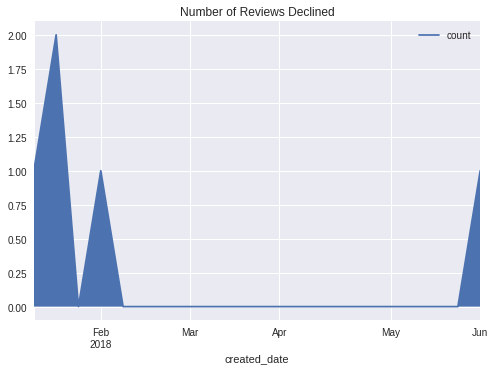

In [7]:
plt.style.use('seaborn')
weekly_df.plot(y='count', use_index=True)
plt.fill_between(y1=weekly_df['count'], y2=0, x=weekly_df.index)
plt.title("Number of Reviews Declined");

We can do the same thing on a monthly basis. As can be expected, the resulting DataFrame, `monthly_df` would have a lesser number of datapoints when compared to `weekly_df`, due to the larger period being considered.

In [8]:
monthly_df = reviews_declined_dated.time_series(period='M')

In [9]:
monthly_df

,count
created_date,
2018-01-31,3
2018-02-28,1
2018-03-31,0
2018-04-30,0
2018-05-31,1


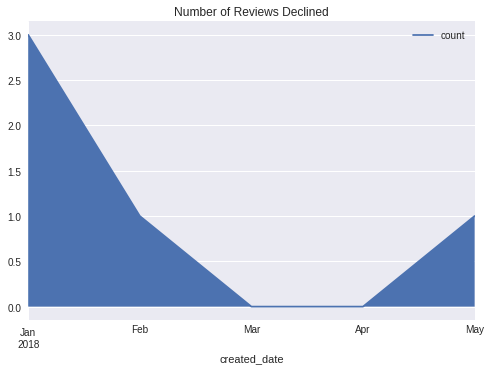

In [10]:
plt.style.use('seaborn')
monthly_df.plot(y='count', use_index=True)
plt.fill_between(y1=monthly_df['count'], y2=0, x=monthly_df.index)
plt.title("Number of Reviews Declined");